# 1. Load the data

In [1]:
# Load keras libraries
import pandas as pd
import numpy as np
import keras

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping

model_path = './Output/LSTM_about_to_fail_model.h5'

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

Using TensorFlow backend.
/Users/saraswathy/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
# Load training data
df_train=pd.read_json('./Dataset/PM_logsynth_train.json', lines=True)
print('Shape of Train dataset: ',df_train.shape)
df_train.head(5)

Shape of Train dataset:  (13538, 5)


,cycle,failure,max_life,s1,s2
0,0,0,577,97,1.176117
1,1,0,577,65,0.000723
2,2,0,577,4,0.921732
3,3,0,577,95,0.177239
4,4,0,577,20,3.626983


# 3. Add labels for RUL and About_To_Fail

In [3]:
# generate label columns for training data
df_train['rul']=df_train['max_life'] - df_train['cycle']
df_train.head(10)

,cycle,failure,max_life,s1,s2,rul
0,0,0,577,97,1.176117,577
1,1,0,577,65,0.000723,576
2,2,0,577,4,0.921732,575
3,3,0,577,95,0.177239,574
4,4,0,577,20,3.626983,573
5,5,0,577,36,0.253401,572
6,6,0,577,57,0.502924,571
7,7,0,577,51,0.186604,570
8,8,0,577,17,0.034710,569
9,9,0,577,83,0.011411,568


In [4]:
# We will make use of "about_to_fail" for binary classification, while trying to answer the question: is a specific 
# engine going to fail within w1 cycles?
w1=50
about_to_fail_window=w1
df_train['about_to_fail'] = np.where(df_train['rul'] <= w1, 1, 0 )
df_train.head(df_train['max_life'][0]+3).tail(6)
#df_train['about_to_fail'] = df_train['rul'].apply(lambda x: 1 if x <= about_to_fail_window else 0)
#df_train.head(df_train['max_life'][0]+3).tail(6)

,cycle,failure,max_life,s1,s2,rul,about_to_fail
574,574,0,577,558,0.782795,3,1
575,575,0,577,664,0.920564,2,1
576,576,0,577,744,1.157950,1,1
577,577,1,577,971,1.111066,0,1
578,578,1,577,912,0.727394,-1,1
579,579,1,577,740,1.056534,-2,1


In [5]:
df_test=pd.read_json('./Dataset/PM_logsynth_test1.json', lines=True)
df_test['rul']=df_test['max_life'] - df_test['cycle']
df_test['about_to_fail'] = df_test['rul'].apply(lambda x: 1 if x <= about_to_fail_window else 0)

In [6]:
features_cols=['cycle','s1','s2','about_to_fail']
# target_col_name='about_to_fail'

# 4. Feature Scaling

In [7]:
df_train.columns.difference(features_cols)

Index(['failure', 'max_life', 'rul'], dtype='object')

In [8]:
min_max_scaler=MinMaxScaler()
cols_normalize = df_train.columns.difference(features_cols)
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(df_train[cols_normalize]), 
                             columns=cols_normalize, 
                             index=df_train.index)
join_df = df_train[df_train.columns.difference(cols_normalize)].join(norm_train_df)
df_train = join_df.reindex(columns = df_train.columns)

In [9]:
cols_normalize = df_test.columns.difference(features_cols)
norm_test_df = pd.DataFrame(min_max_scaler.fit_transform(df_test[cols_normalize]), 
                             columns=cols_normalize, 
                             index=df_test.index)
join_df = df_test[df_test.columns.difference(cols_normalize)].join(norm_test_df)
df_test = join_df.reindex(columns = df_test.columns)

# df_train[features_col_name]=min_max_scaler.fit_transform(df_train[features_col_name])
# df_test[features_col_name]=min_max_scaler.transform(df_test[features_col_name])

In [10]:
df_train.head()

,cycle,failure,max_life,s1,s2,rul,about_to_fail
0,0,0.0,0.252632,97,1.176117,0.899291,0
1,1,0.0,0.252632,65,0.000723,0.897872,0
2,2,0.0,0.252632,4,0.921732,0.896454,0
3,3,0.0,0.252632,95,0.177239,0.895035,0
4,4,0.0,0.252632,20,3.626983,0.893617,0


In [11]:
df_test.head()

,cycle,failure,max_life,s1,s2,rul,about_to_fail
0,0,0.0,0.0,88,1.012152,1.000000,0
1,1,0.0,0.0,94,0.425117,0.998331,0
2,2,0.0,0.0,12,0.071812,0.996661,0
3,3,0.0,0.0,72,0.008297,0.994992,0
4,4,0.0,0.0,58,4.495535,0.993322,0


In [12]:
#Function to split the original time-series into sequences of length seq_length.
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

In [13]:
# function to generate labels
def gen_label(id_df, seq_length, seq_cols, label):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

In [14]:
# split the training data into sub-sequences of length seq_length
seq_length=100
seq_cols=features_cols=['cycle','s1','s2']
df_train.head(5)

,cycle,failure,max_life,s1,s2,rul,about_to_fail
0,0,0.0,0.252632,97,1.176117,0.899291,0
1,1,0.0,0.252632,65,0.000723,0.897872,0
2,2,0.0,0.252632,4,0.921732,0.896454,0
3,3,0.0,0.252632,95,0.177239,0.895035,0
4,4,0.0,0.252632,20,3.626983,0.893617,0


# Reformat training data and test data into the [samples, time steps, features] format.

In [15]:
# generate X_train
X_train=np.array(list(gen_sequence(df_train, seq_length, seq_cols)))
print(X_train.shape)
print(df_train[0:10])
print(df_train[96:105][:])
print(X_train[96:105])
# generate y_train
y_train=np.array(list(gen_label(df_train, seq_length, seq_cols, 'about_to_fail')))
print(y_train.shape)

(13537, 100, 3)
   cycle  failure  max_life  s1        s2       rul  about_to_fail
0      0      0.0  0.252632  97  1.176117  0.899291              0
1      1      0.0  0.252632  65  0.000723  0.897872              0
2      2      0.0  0.252632   4  0.921732  0.896454              0
3      3      0.0  0.252632  95  0.177239  0.895035              0
4      4      0.0  0.252632  20  3.626983  0.893617              0
5      5      0.0  0.252632  36  0.253401  0.892199              0
6      6      0.0  0.252632  57  0.502924  0.890780              0
7      7      0.0  0.252632  51  0.186604  0.889362              0
8      8      0.0  0.252632  17  0.034710  0.887943              0
9      9      0.0  0.252632  83  0.011411  0.886525              0
     cycle  failure  max_life  s1        s2       rul  about_to_fail
96      96      0.0  0.252632  75  1.122721  0.763121              0
97      97      0.0  0.252632  62  0.780835  0.761702              0
98      98      0.0  0.252632  93  0.735

In [16]:
# generate X_test
X_test=np.array(list(gen_sequence(df_test, seq_length, seq_cols)))
print(X_test.shape)
# generate y_test
y_test=np.array(list(gen_label(df_test, seq_length, seq_cols, 'about_to_fail')))
print(y_test.shape)
print(y_test[0:600])

(599, 100, 3)
(599,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [17]:
nb_features =X_train.shape[2]
timestamp=seq_length
label_gen = list(gen_label(df_test, seq_length, seq_cols, 'about_to_fail'))
label_array = np.array(label_gen).astype(np.float32)
label_array.shape
# nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(input_shape=(timestamp, nb_features),units=100,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

# fit the network
history = model.fit(X_train, y_train, epochs=2, batch_size=10, validation_split=0.05, #verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 100)          41600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 71,851
Trainable params: 71,851
Non-trainable params: 0
_________________________________________________________________
Train on 12860 samples, validate on 677 samples
Epoch 1/2
12860/12860 [==============================] - 284s 22ms/step - loss: 0.0530 - a

# Sanity check model accuracy and loss

NameError: name 'saved_history' is not defined

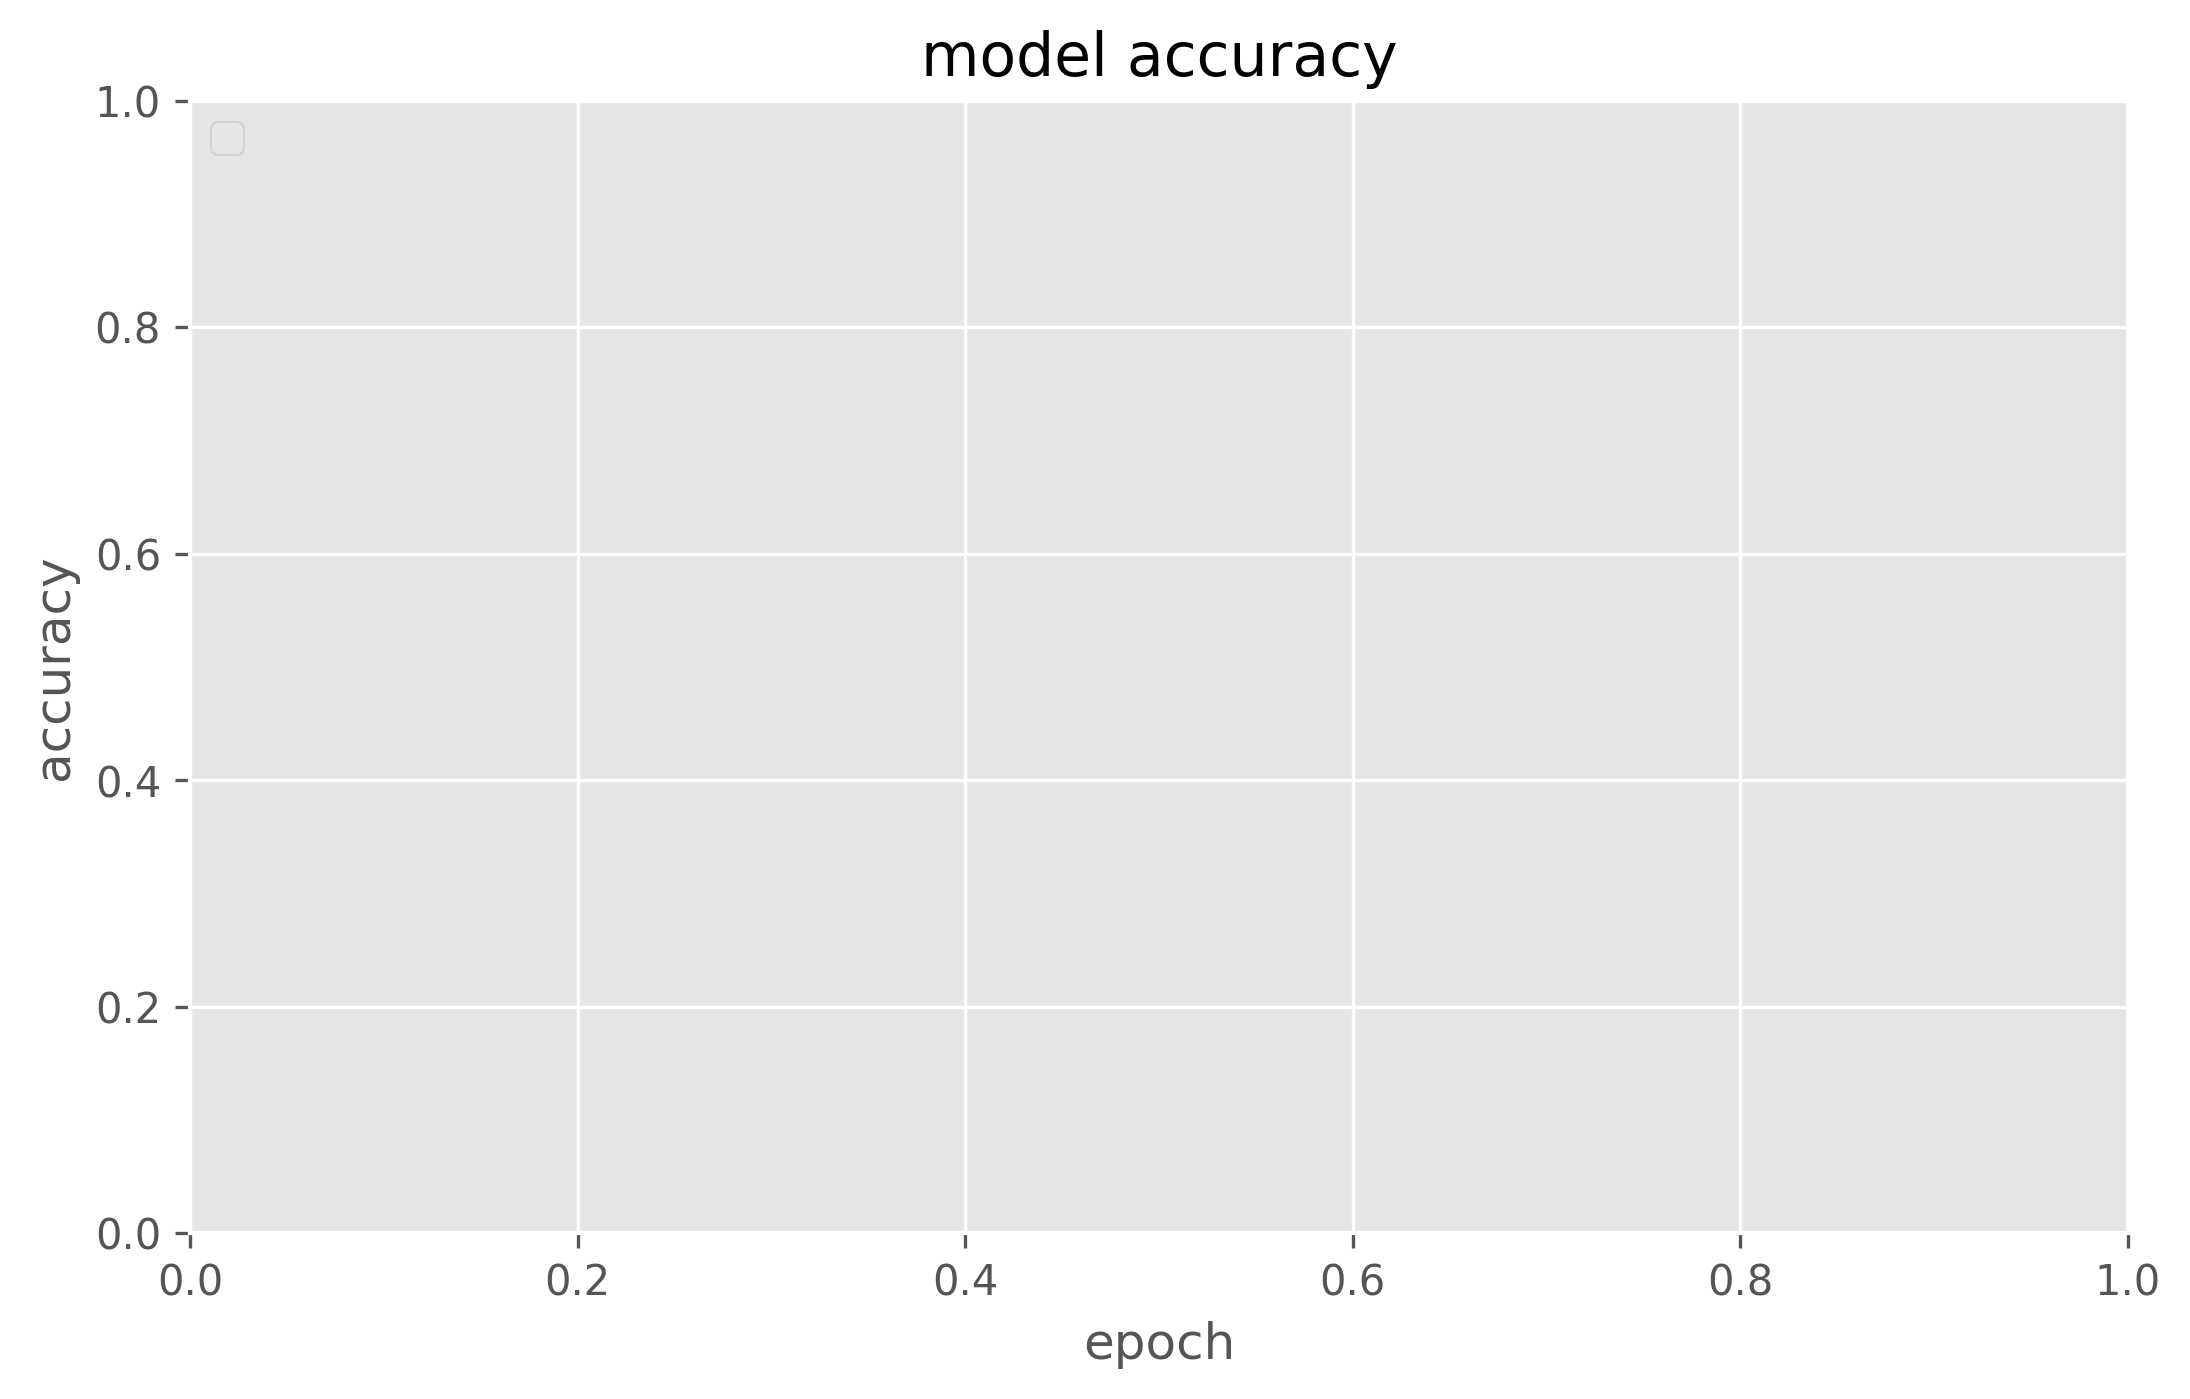

In [32]:
#Accuracy should be great than 0.9, and loss should be less than 0.1.
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(20, 5), dpi=300)
plt.subplot(1, 2, 1)
plt.subplots_adjust(hspace=.4, wspace=.4)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.plot(saved_history['acc'])
plt.plot(saved_history['val_acc'])
# plt.show()
# fig_acc.savefig("./Output/model_accuracy.png")

# summarize history for Loss
plt.subplot(1, 2, 2)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.plot(saved_history['loss'])
plt.plot(saved_history['val_loss'])
# plt.show()
# fig_acc.savefig("./Output/model_loss.png")

# Save the model

In [19]:
##################################
# Save model and training history
##################################

import pickle
filename = open("./Output/LSTM_about_to_fail_model_history","wb")
pickle.dump(history.history, filename)
filename.close()
        
# serialize model to JSON
model_json = model.to_json()
with open("./Output/LSTM_about_to_fail_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./Output/LSTM_about_to_fail_model.h5")
print("Saved model to disk")

Saved model to disk


# Load the model

In [20]:
###########################################
# Load model and training history from disk
###########################################
import pickle
history_file = open("./Output/LSTM_about_to_fail_model_history","rb")
history = pickle.load(history_file)
history_file.close()

# Load model from disk
from keras.models import model_from_json
# load json and create model
json_file = open("./Output/LSTM_about_to_fail_model.json", "r")
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("./Output/LSTM_about_to_fail_model.h5")
print("Loaded model from disk")
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Loaded model from disk


In [21]:
# make predictions and compute confusion matrix
scores = model.evaluate(X_train, y_train, verbose=1, batch_size=200)
y_pred = model.predict_classes(X_train, verbose=1, batch_size=200)
y_true = y_train
# test_set = pd.DataFrame(y_pred)
#test_set.to_csv('./Output/binary_submit_train.csv', index = None)
print('Accuracy of predictions made on data used for training:\n{}'.format(scores[1]))
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ' + str(precision) + '\nrecall = ' + str(recall))

13537/13537 [==============================] - 12s 904us/step
Accuracy of predictions made on data used for training:
0.9882544177255013
precision = 0.9431602879878742
recall = 0.9963971176941553


# Compare predictions vs actual data

In [22]:
print('Confusion matrix on training data:\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
pd.DataFrame(cm).head(2)

Confusion matrix on training data:
- x-axis is true labels.
- y-axis is predicted labels


,0,1
0,10889,150
1,9,2489


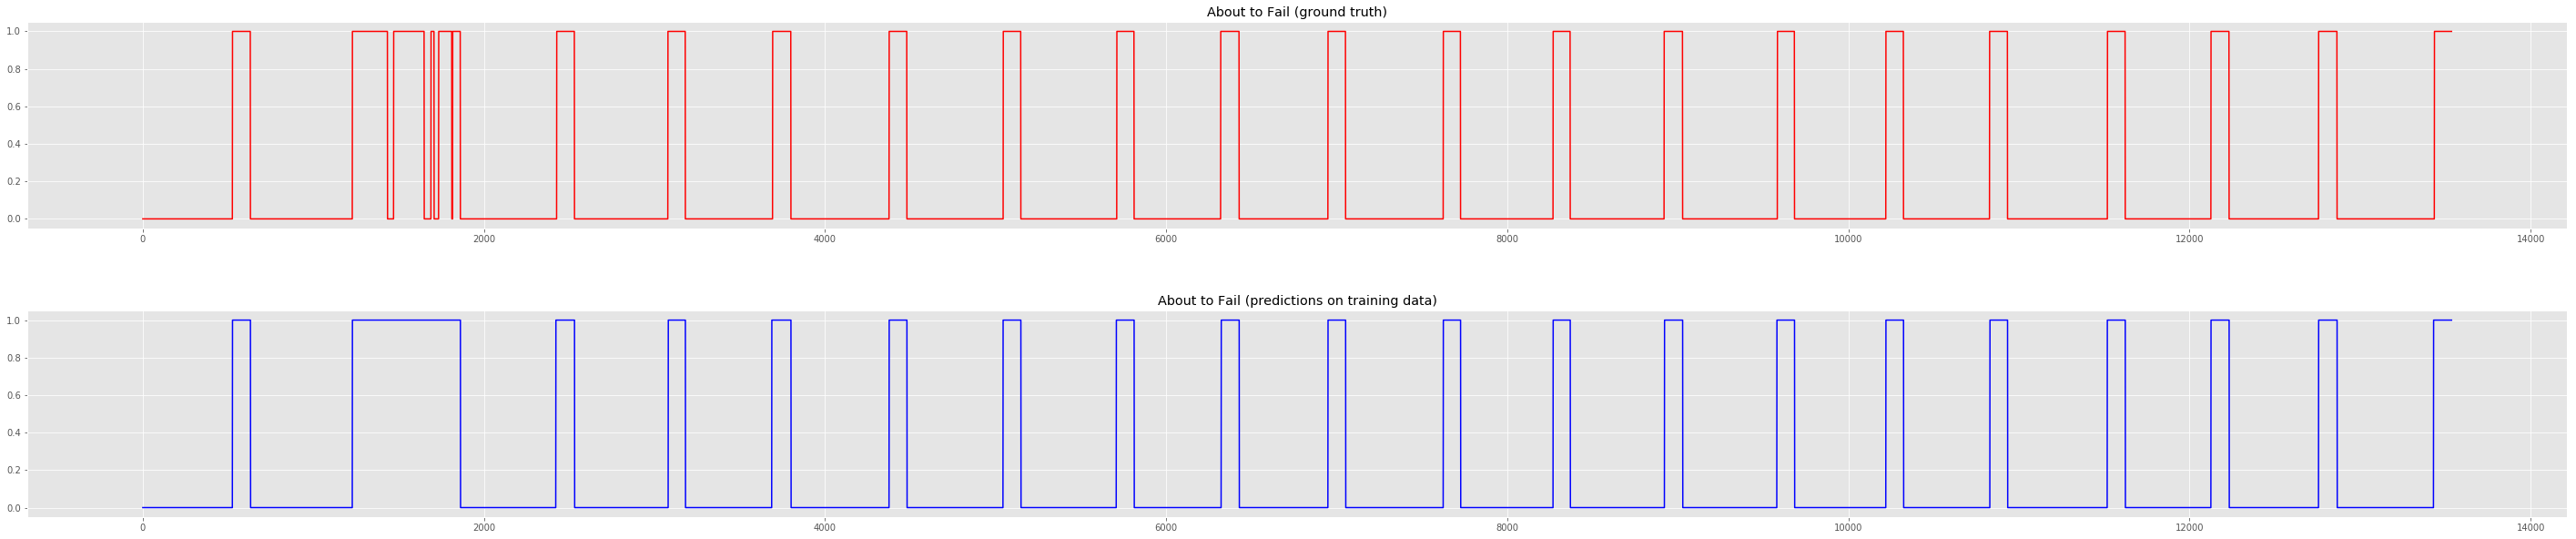

In [23]:
plt.figure(figsize=(50, 10))
plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace=.4, wspace=.4)
plt.title("About to Fail (ground truth)")
plt.plot(y_true,'r')
plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=.4, wspace=.4)
plt.title("About to Fail (predictions on training data)")
plt.plot(y_pred,'b')

In [24]:
y_pred2=model.predict_classes(X_test)
print('Accuracy of model on test data: ' + str(accuracy_score(y_test,y_pred2)))
print('Confusion matrix on training data:\n- x-axis is true labels.\n- y-axis is predicted labels')
pd.DataFrame(confusion_matrix(y_test,y_pred2)).head(2)

Accuracy of model on test data: 0.9115191986644408
Confusion matrix on training data:
- x-axis is true labels.
- y-axis is predicted labels


,0,1
0,499,0
1,53,47


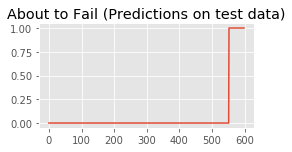

In [25]:
plt.figure(figsize=(20, 10))
plt.subplot(4, 4, 1)
plt.subplots_adjust(hspace=.4, wspace=.4)
plt.title("About to Fail (Predictions on test data)")
plt.plot(y_pred2)

# Functions for predicting failures

In [27]:
def prob_failure(df):
    test = gen_sequence(df,seq_length,seq_cols)
    m_pred = model.predict(test)
    failure_prob=list(m_pred[-1])[0]
    return failure_prob

def plot_prediction(df):
    X_test3=np.array(list(gen_sequence(df, seq_length, seq_cols)))
    y_test3=np.array(list(gen_label(df_test, seq_length, seq_cols, 'about_to_fail')))
    y_pred3=model.predict_classes(X_test3)
    confidence = model.predict(gen_sequence(df,seq_length,seq_cols))
    plt.figure(figsize=(20, 10), dpi=300)
    plt.subplot(4, 4, 1)
    plt.subplots_adjust(hspace=.4, wspace=.4)
    plt.title("About to Fail Within "+str(about_to_fail_window)+" cycles")
    plt.ylim(-.1, 1.1)
    plt.xlabel('cycles')
    plt.yticks(np.arange(2), ('False', 'True'))
    plt.plot(df['about_to_fail'], 'r', label='actual')
    plt.plot(y_pred3, 'b', label='predicted')
    plt.legend(loc='upper left')
    plt.subplot(4, 4, 2)
    plt.title("Probability of Failure")
    plt.ylim(-.1, 1.1)
    plt.xlabel('cycles')
    plt.plot(confidence,'r')
    print("Probability of failure within " + str(about_to_fail_window) + " cycles: {0:.1%}".format(prob_failure(df)))
    print('Accuracy Score: {0:.2}'.format(accuracy_score(y_test3,y_pred3)))
    print('Confusion matrix:\n- x-axis is true labels.\n- y-axis is predicted labels')
    print(pd.DataFrame(confusion_matrix(y_test3,y_pred3)).head(2))

# Model Tests

Probability of failure within 50 cycles: 97.5%
Accuracy Score: 0.91
Confusion matrix:
- x-axis is true labels.
- y-axis is predicted labels
     0   1
0  499   0
1   53  47


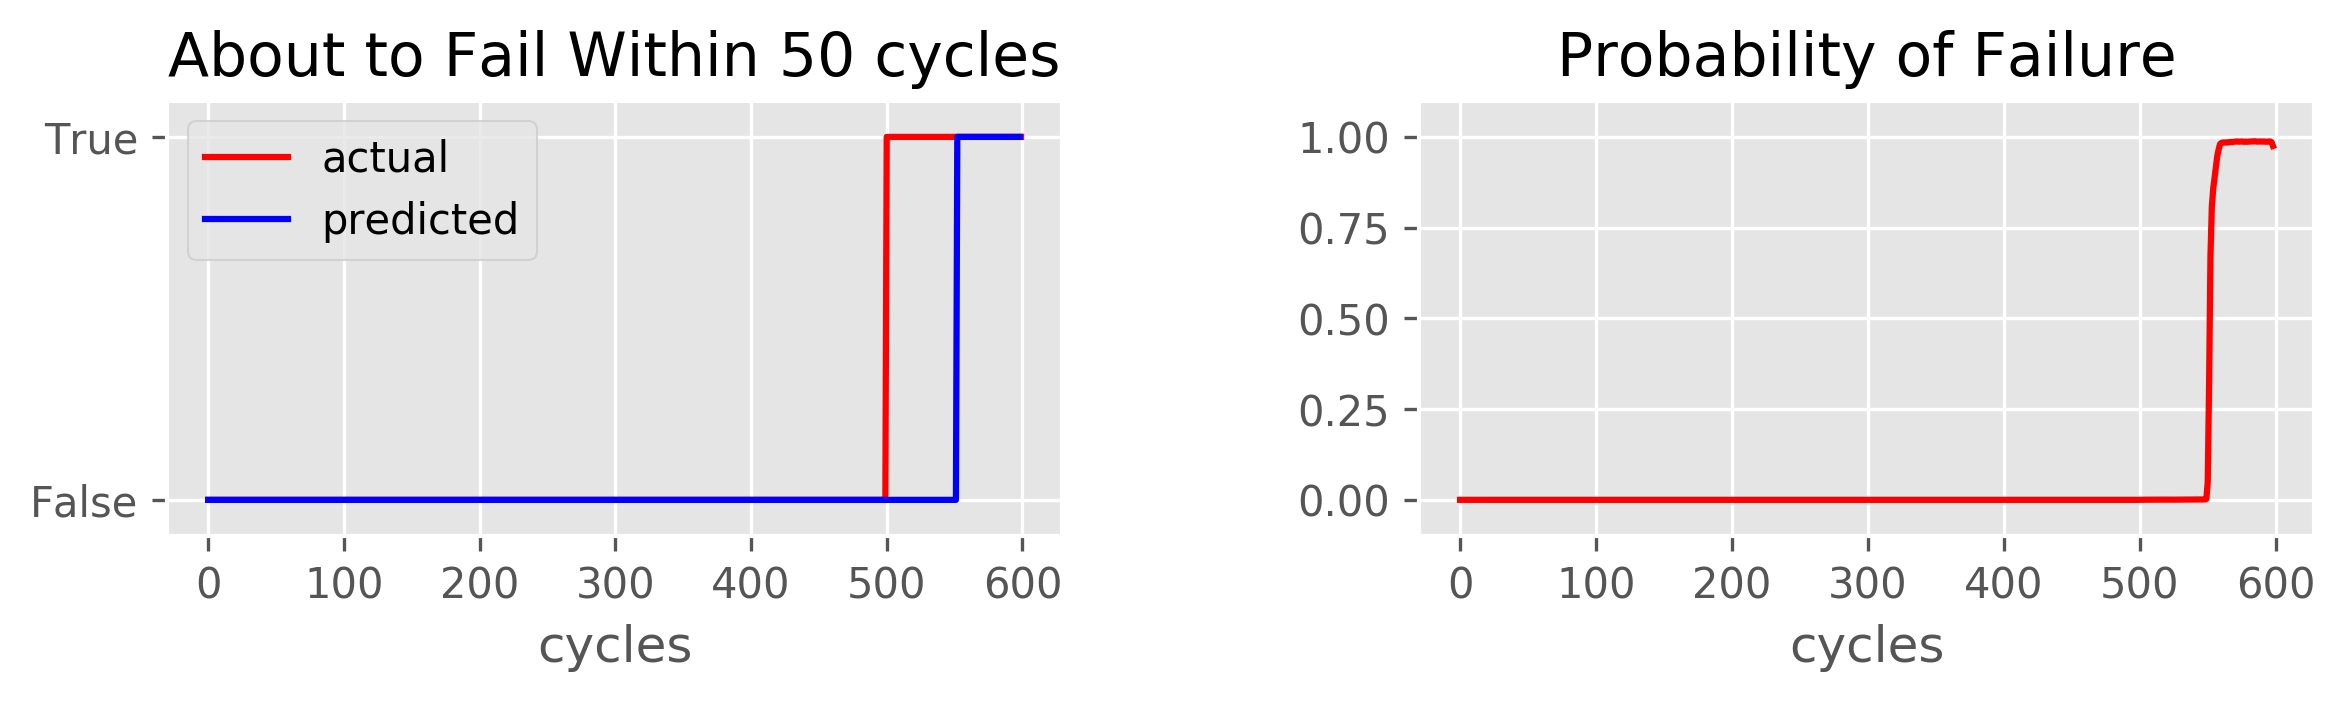

In [29]:
df=pd.read_json('./Dataset/PM_logsynth_test1.json', lines=True)
df['rul']=df['max_life'] - df['cycle']
df['about_to_fail'] = np.where(df['rul'] <= w1, 1, 0 )
plot_prediction(df)

In [31]:
df=pd.read_json('./Dataset/PM_logsynth_test2.json', lines=True)
df['rul']=df['max_life'] - df['cycle']
df['about_to_fail'] = np.where(df['rul'] <= w1, 1, 0 )
plot_prediction(df)

ValueError: Expected object or value

In [ ]:
df=pd.read_json('./Dataset/PM_logsynth_test3.json', lines=True)
df['rul']=df['max_life'] - df['cycle']
df['about_to_fail'] = np.where(df['rul'] <= w1, 1, 0 )
plot_prediction(df)

In [ ]:
df=pd.read_json('./Dataset/PM_logsynth_test4.json', lines=True)
df['rul']=df['max_life'] - df['cycle']
df['about_to_fail'] = np.where(df['rul'] <= w1, 1, 0 )
plot_prediction(df)